In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sys
from p5lib import *
import pickle
import os.path

%matplotlib inline

### Load and preprocess data

The method ```preprocess_data``` chooses only the selected potential features and combine some columns that are mutually exclusive (such as 4 year college and < 4 year college). It also removes data that does not have Completion or Retention data because those are the target features. 

The result from preprocessing is stored in a pickle file so we can reload it much faster. 

In [108]:
pickle_file = 'reduced_data.pickle'
if os.path.isfile(pickle_file):
    data = pickle.load(open(pickle_file, "rb"))
else:
    data = pd.read_csv('MERGED2013_PP.csv')
    # print data.shape
    data = preprocess_data(data)
    pickle.dump(data, open(pickle_file, "wb"))

print data.shape

(6007, 45)


### Split data into features and targets (X and y) 

We also get rid of data that are outliers (data with retention rate 0)

In [109]:
X = data[['CONTROL', 'DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'PAR_ED_PCT_1STGEN', 
          'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 'UG25abv', 'UGDS', 
          'WDRAW_DEBT_MDN', 'L4_COLLEGE', 'NPT4', 'NUM4', 
          'PFTFTUG1_EF', 'PFTFAC',
          'SAT_AVG_ALL', 'ACTCMMID', 'ADM_RATE_ALL', 'AVGFACSAL', 'COSTT4_A',
          'CCSIZSET', 'CCUGPROF', 'CCBASIC', # carnegie classification data
          'C150', 'RET_FT']]

# remove noise, this bumps up the r2 score pretty nicely
# X = X[~((X.RET_FT == 0) & (X.C150 > 0.5))]
# X = X[~((X.C150 == 0) & (X.RET_FT > 0.5))]
# X = X[~((X.C150 == 1) & (X.RET_FT < 0.5))]
# X = X[~((X.RET_FT == 1) & (X.C150 < 0.5))]
X = X[~(X.RET_FT == 0)]

y = X[['C150', 'RET_FT']]
X = X.drop('C150', 1)
X = X.drop('RET_FT', 1)
print X.shape
print y.shape
print len(X.dropna())


(5960, 28)
(5960, 2)
1146


### Fill missing values with the means

In [110]:
fill_cols_with_mean = ['DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'WDRAW_DEBT_MDN',
                       'PAR_ED_PCT_1STGEN', 'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 
                       'UG25abv', 'NPT4', 'NUM4', 'PFTFTUG1_EF', 'PFTFAC', 'SAT_AVG_ALL', 'ACTCMMID', 'ADM_RATE_ALL', 
                       'AVGFACSAL', 'COSTT4_A']

for col in fill_cols_with_mean:
    if col in X:
        X[col] = X[col].fillna(X[col].mean())

In [111]:
print_num_data_for_each_features(X)

Number of available data for each feature (not counting the NaN values)
CONTROL             Control (public/private)                      5960
DEBT_MDN            Median debt                                   5960
DEP_INC_AVG         Avg income dependent stu                      5960
GRAD_DEBT_MDN       Median debt complete                          5960
IND_INC_AVG         Avg income independent stu                    5960
INEXPFTE            Expense per FTE student                       5960
PAR_ED_PCT_1STGEN   % 1st gen students                            5960
PAR_ED_PCT_HS       % parent education high school                5960
PAR_ED_PCT_MS       % parent education middle school              5960
PAR_ED_PCT_PS       % parent education post secondary             5960
PCTFLOAN            % Fed student loan                            5960
PCTPELL             % Pell Grant receiver                         5960
UG25abv             % undergrad > 25 yr                           5960
UGDS 

### Scale data

Process non-categorical data using standard scaler so they all have 0 means. 

In [112]:
from sklearn import preprocessing

# take features of type cost/money, and percentage (between 0 and 1) and preprocess with standard scaler
# and then use these preprocessed features for PCA
tmpX = X[['DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'UGDS', 'WDRAW_DEBT_MDN', 'NPT4', 
          'NUM4', 'SAT_AVG_ALL', 'ACTCMMID', 'AVGFACSAL', 'COSTT4_A',
          'PAR_ED_PCT_1STGEN', 'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 'UG25abv', 
          'PFTFTUG1_EF', 'PFTFAC', 'ADM_RATE_ALL'
         ]]

scaler = preprocessing.StandardScaler()
scaledX = scaler.fit_transform(tmpX)

tmp1X = np.array(pd.get_dummies(X['CONTROL']))
tmp2X = X['L4_COLLEGE'].astype(int)
tmp2X = np.reshape(tmp2X, (len(tmp2X), 1)) 

tmp3X = np.array(pd.get_dummies(X['CCSIZSET']))
tmp4X = np.array(pd.get_dummies(X['CCUGPROF']))
tmp5X = np.array(pd.get_dummies(X['CCBASIC']))

print scaledX.shape

print tmp1X.shape, tmp2X.shape, tmp3X.shape, tmp4X.shape, tmp5X.shape

scaledX = np.concatenate((scaledX, tmp1X, tmp2X, tmp3X, tmp4X, tmp5X), axis=1)
print scaledX.shape

(5960, 23)
(5960, 3) (5960, 1) (5960, 17) (5960, 14) (5960, 33)
(5960, 91)


### Use PCA for dimensional reduction

[  3.06028059e-01   1.17407816e-01   9.40599092e-02   6.24552170e-02
   5.32764746e-02   4.42813632e-02   3.83597636e-02   3.56425121e-02
   3.15363550e-02   2.51473280e-02   2.28732216e-02   2.07834903e-02
   2.01741285e-02   1.51743857e-02   1.15420918e-02   9.50541318e-03
   8.02426084e-03   6.89820006e-03   6.76003179e-03   5.61559594e-03
   4.84117907e-03   4.04233349e-03   3.90588228e-03   3.22490738e-03
   2.98813273e-03   2.76087430e-03   2.59057567e-03   2.43586401e-03
   2.22033809e-03   1.95514384e-03   1.91988889e-03   1.85666806e-03
   1.83123163e-03   1.66116390e-03   1.36646398e-03   1.27867204e-03
   1.20633962e-03   1.13003442e-03   1.04875494e-03   1.03896107e-03
   9.87322403e-04   9.67347303e-04   9.58722647e-04   9.39616454e-04
   8.98332101e-04   8.64535271e-04   8.31874725e-04   7.82476221e-04
   7.49433509e-04   7.07036685e-04   6.77430875e-04   6.48898803e-04
   6.20559089e-04   5.93634020e-04   5.90601227e-04   5.61771542e-04
   5.45724301e-04   5.20951713e-04

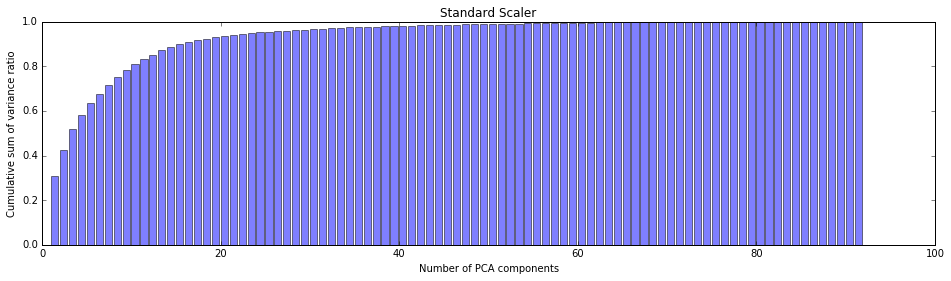

In [113]:
from sklearn.decomposition import PCA

pca = PCA(n_components=scaledX.shape[1])
pca.fit(scaledX)

print pca.explained_variance_ratio_

plt.figure(figsize=(16,4))
plt.title('Standard Scaler')
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), alpha=0.5)
plt.ylabel('Cumulative sum of variance ratio')
plt.xlabel('Number of PCA components')
plt.show()

The first 35 PCA components seem to count for more than 95% of the variance. 

In [114]:
pca = PCA(n_components=35)
pca.fit(scaledX)
finalX = pca.transform(scaledX)

print finalX.shape

(5960, 35)


### Train / test split

Optionally store the train/test split in a pickle file if we want to keep the same train/test data. In order to do this, comment out the os.remove line. 

(4768, 35)
(1192, 35)
(4768, 2)
(1192, 2)
       y_test c150  y_train c150
count  1192.000000   4768.000000
mean      0.527043      0.527613
std       0.240741      0.236402
min       0.000000      0.000000
25%       0.329263      0.339001
50%       0.548945      0.552941
75%       0.726407      0.716580
max       1.000000      1.000000
        y_test ret  y_train ret
count  1192.000000  4768.000000
mean      0.699490     0.697777
std       0.163967     0.169503
min       0.153800     0.019200
25%       0.591125     0.590900
50%       0.703050     0.710300
75%       0.818200     0.818200
max       1.000000     1.000000


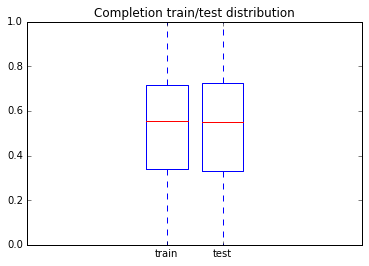

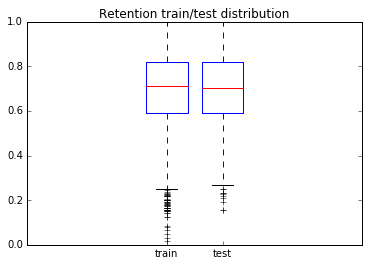

In [115]:
from sklearn import cross_validation as cv

pickle_file = 'm5-split_data.pickle'

os.remove(pickle_file) # clear cache (delete pickle). Comment this out to keep the same train/test data over multiple runs
if os.path.isfile(pickle_file):
    print "loading split_data from pickle"
    split_data = pickle.load(open(pickle_file, "rb"))
    X_train, X_test, y_train, y_test = split_data['X_train'], split_data['X_test'], split_data['y_train'], split_data['y_test']
else:
    y = np.array(y)
    X_train, X_test, y_train, y_test = cv.train_test_split(finalX, y, train_size=0.8)
    split_data = {
        'X_train': X_train,
        'X_test':  X_test,
        'y_train': y_train,
        'y_test':  y_test,        
    }
    pickle.dump(split_data, open(pickle_file, "wb"))

print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

# Check if the train / test has similar distribution
print pd.DataFrame(data={'y_train c150': pd.Series(y_train[:,0]).describe(),
                         'y_test c150': pd.Series(y_test[:,0]).describe(),
                        })
print pd.DataFrame(data={'y_train ret': pd.Series(y_train[:,1]).describe(),
                         'y_test ret': pd.Series(y_test[:,1]).describe(),
                        })
plt.title("Completion train/test distribution")
plt.boxplot([y_train[:,0], y_test[:,0]], labels=['train', 'test'], positions=[0.2, 0.4])
plt.show()
plt.title("Retention train/test distribution")
plt.boxplot([y_train[:,1], y_test[:,1]], labels=['train', 'test'], positions=[0.2, 0.4])
plt.show()


## Build models

X_train contains the following data:
* The first 15 columns are PCA reduced data from the 23 numerical features
* Column 16-19 are one hot encoded categorical data (4 year college, public, private, profit)
* Column 20-83 are one hot encoded remaining caegorical data (Carnegie classifications) 

### Decision Tree

--- R2 Completion ---
best params: {'max_depth': 6}
R2 score on train data: 0.638654695534
R2 score on test  data: 0.543380584155
--- R2 Retention ---
best params: {'max_depth': 6}
R2 score on train data: 0.342263810212
R2 score on test  data: 0.270238962664
--- MSE Completion ---
MSE on train data: 0.0201899049895
MSE on test  data: 0.0264417425535
--- MSE Retention ---
MSE on train data: 0.0188937063395
MSE on test  data: 0.019603234115
--- MAE Completion ---
MAE on train data: 0.105796290938
MAE on test  data: 0.118666261163
--- MAE Retention ---
MAE on train data: 0.0979960641255
MAE on test  data: 0.101740522399


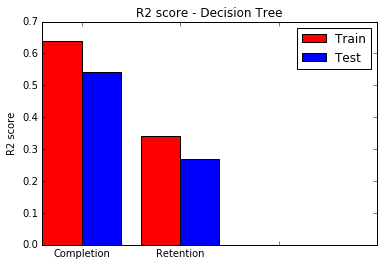

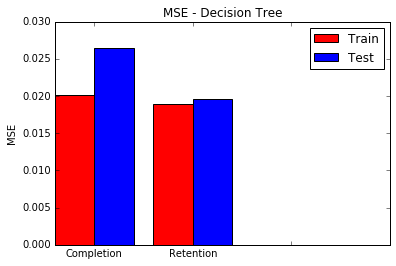

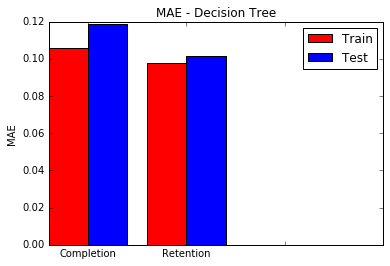

In [116]:
DT_model = build_DecisionTree_model(X_train, X_test, y_train, y_test)

### SVR

--- R2 Completion ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.755981833053
R2 score on test  data: 0.688439015031
--- R2 Retention ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.485461458913
R2 score on test  data: 0.367606491247
--- MSE Completion ---
MSE on train data: 0.0136343368669
MSE on test  data: 0.0180417543985
--- MSE Retention ---
MSE on train data: 0.014780302873
MSE on test  data: 0.0169876951092
--- MAE Completion ---
MAE on train data: 0.0891301340751
MAE on test  data: 0.101377733946
--- MAE Retention ---
MAE on train data: 0.0872077783693
MAE on test  data: 0.0962905227431


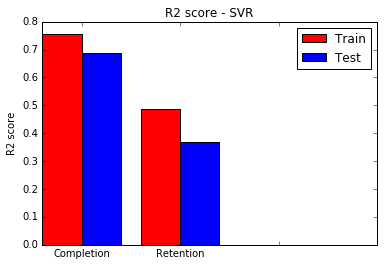

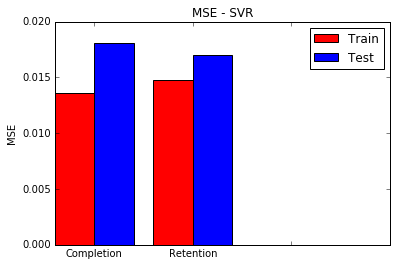

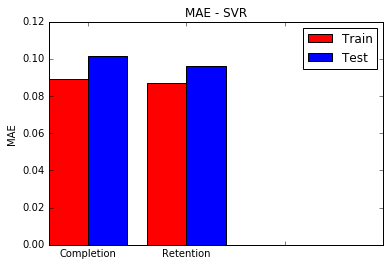

In [117]:
SVR_model = build_SVR_model(X_train, X_test, y_train, y_test)

### KNN

--- R2 Completion ---
best params: {'n_neighbors': 8}
R2 score on train data: 0.745121969325
R2 score on test  data: 0.701127467644
--- R2 Retention ---
best params: {'n_neighbors': 17}
R2 score on train data: 0.408194905151
R2 score on test  data: 0.384879528972
--- MSE Completion ---
MSE on train data: 0.0142411238216
MSE on test  data: 0.0173069963358
--- MSE Retention ---
MSE on train data: 0.0169998121525
MSE on test  data: 0.0165236974647
--- MAE Completion ---
MAE on train data: 0.0858364984009
MAE on test  data: 0.0958217539383
--- MAE Retention ---
MAE on train data: 0.0908867745756
MAE on test  data: 0.0937485096723


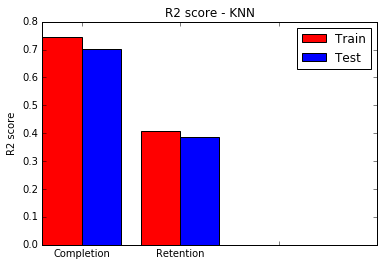

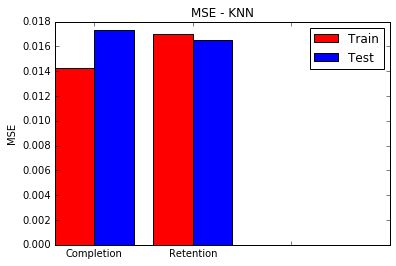

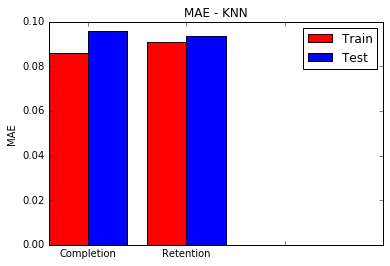

In [118]:
KNN_model = build_KNN_model(X_train, X_test, y_train, y_test)

### Random Forest

--- R2 Completion ---
R2 score on train data: 0.952025431955
R2 score on test  data: 0.700853855757
--- R2 Retention ---
R2 score on train data: 0.907775917272
R2 score on test  data: 0.400603460863
--- MSE Completion ---
MSE on train data: 0.00268054395277
MSE on test  data: 0.0173228405483
--- MSE Retention ---
MSE on train data: 0.00264916962688
MSE on test  data: 0.0161013127356
--- MAE Completion ---
MAE on train data: 0.0369981177696
MAE on test  data: 0.0965126602531
--- MAE Retention ---
MAE on train data: 0.0356649711055
MAE on test  data: 0.0917247646552


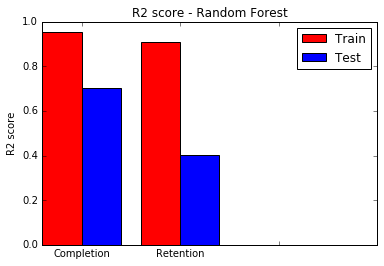

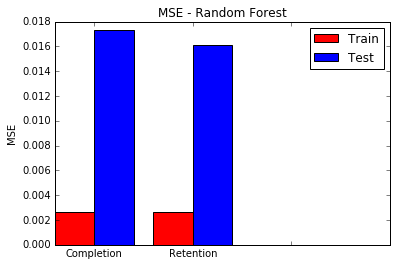

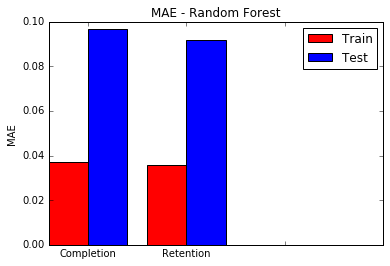

In [119]:
RF_model = build_RandomForest_model(X_train, X_test, y_train, y_test, n_estimators=50)

### Comparing R2, MSE and MAE between models

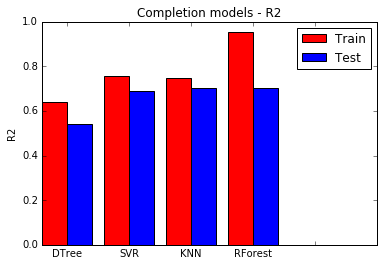

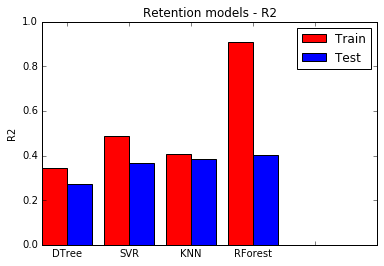

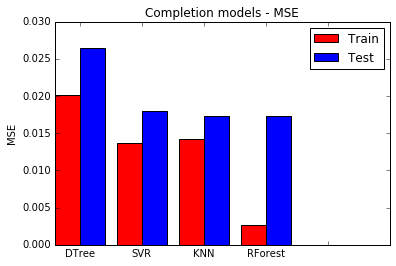

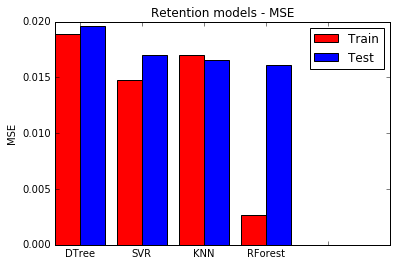

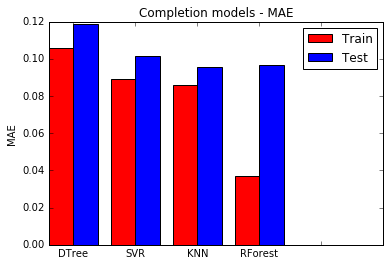

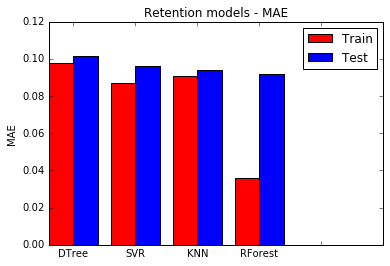

In [120]:
plot_compare_metric([DT_model, SVR_model, KNN_model, RF_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='r2')
plot_compare_metric([DT_model, SVR_model, KNN_model, RF_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='mse')
plot_compare_metric([DT_model, SVR_model, KNN_model, RF_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='mae')

### Sensitivity analysis

Sensitivity analysis is done by choosing 100 random data from the training set and changing the input by a little bit to see how different the prediction result for each model is. The difference in prediction result are collected and visualized using whisker plot to see the stability of the model.

Statistical analysis of difference in result when the input have small changes


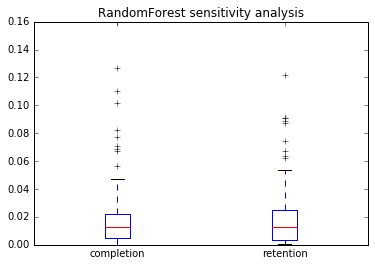

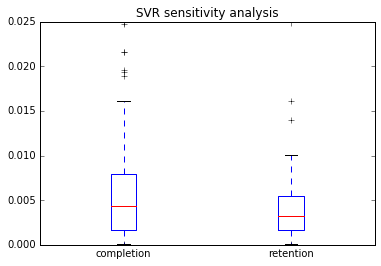

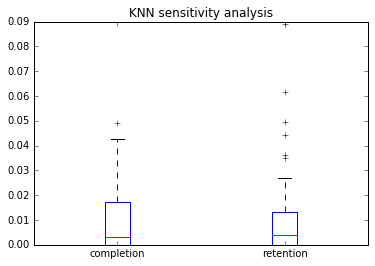

In [121]:

def final_model_predict(reg1, reg2, X):
    y1_predicted = reg1.predict(X)
    y2_predicted = reg2.predict(X)
    return y1_predicted, y2_predicted

def sensitivity_analysis(reg1, reg2, data, title=''):
    delta_y1, delta_y2 = [], []
    
    for i, row in enumerate(data):
        X_nearby = row.copy()
        for j, a in enumerate(X_nearby):
            span = X_train[:,j].max() - X_train[:,j].min()
            if j < 15:
                X_nearby[j] += span/200

        y1p, y2p = final_model_predict(reg1, reg2, [row]) # predicted value
        y1pn, y2pn = final_model_predict(reg1, reg2, [X_nearby]) # predicted nearby value
        delta_y1.append(abs(y1pn[0] - y1p[0]))
        delta_y2.append(abs(y2pn[0] - y2p[0]))
    
    plt.title("{} sensitivity analysis".format(title))
    plt.boxplot([delta_y1, delta_y2], labels=['completion', 'retention'])
    plt.show()

print "Statistical analysis of difference in result when the input have small changes"
# Just test on a subset of the data (because it's really slow)
X_train_subset = X_train[np.random.choice(len(X_train), 100, replace=False)]

sensitivity_analysis(RF_model['reg1'], RF_model['reg2'], data=X_train_subset, title='RandomForest')
sensitivity_analysis(SVR_model['reg1'], SVR_model['reg2'], data=X_train_subset, title='SVR')
sensitivity_analysis(KNN_model['reg1'], KNN_model['reg2'], data=X_train_subset, title='KNN')


### Prediction error distribution

Metric only goes so far as telling as the mean absolute error, or the R2 score with just one number. 
To get a better idea how our model performs, we'll look at the prediction error on the test data and create histogram of the error distribution, so we can tell what's the percentage the model get it close, and what's the percentage it does really poorly.

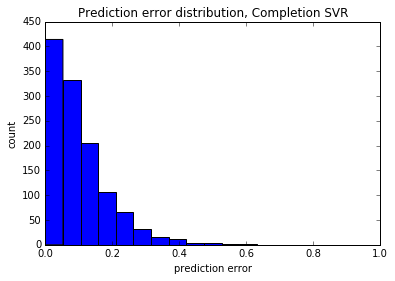

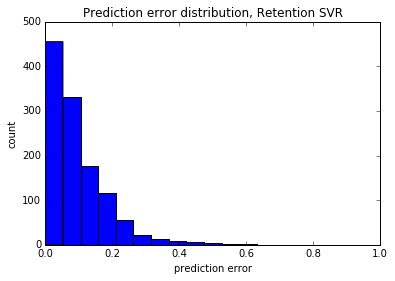

In [122]:
hist_plot_delta(SVR_model, X_test, y_test, model_name='SVR')

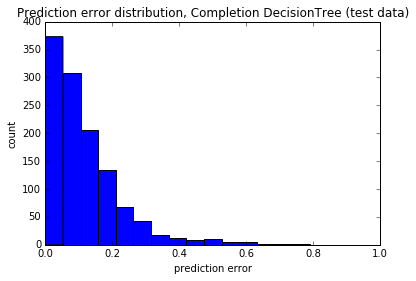

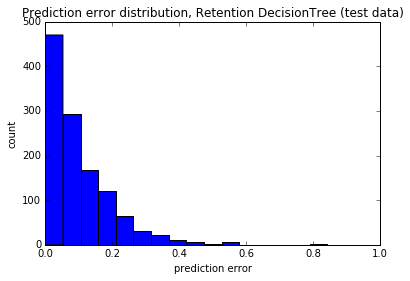

In [123]:
hist_plot_delta(DT_model, X_test, y_test, model_name='DecisionTree (test data)')

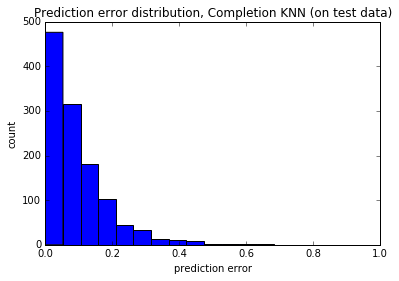

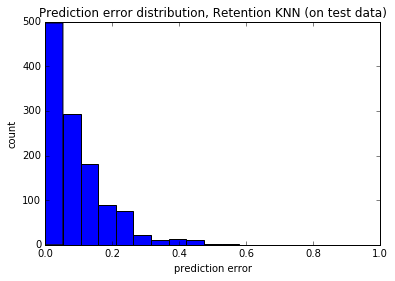

In [124]:
hist_plot_delta(KNN_model, X_test, y_test, model_name='KNN (on test data)')

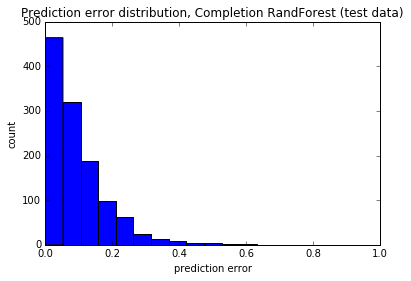

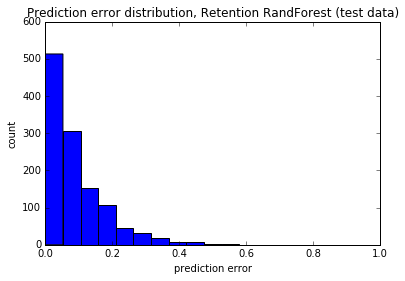

In [125]:
hist_plot_delta(RF_model, X_test, y_test, model_name='RandForest (test data)')

### Error distribution comparison between models

The following histogram plots show how different models perform. Even though some models have similar R2 and MAE, they don't always make the same prediction. This comparison shows how the models trade off error distribution.

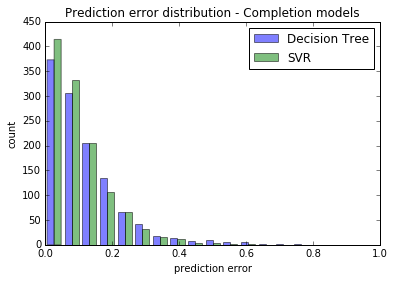

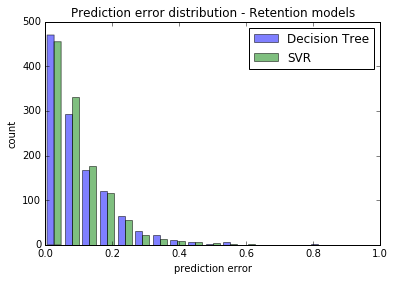

In [126]:
compare_hist_plot_delta(DT_model, SVR_model, X_test, y_test, ['Decision Tree', 'SVR'])

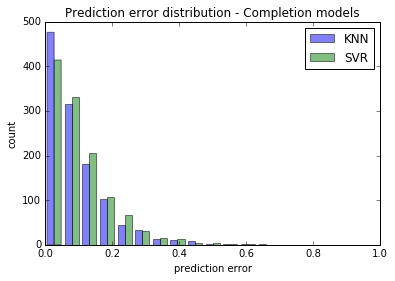

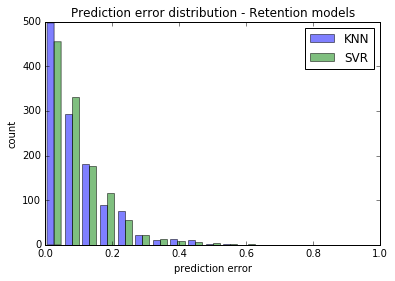

In [127]:
compare_hist_plot_delta(KNN_model, SVR_model, X_test, y_test, ['KNN', 'SVR'])